# Exploring the Alzheimer's prediction dataset from [kaggle](https://www.kaggle.com/datasets/ankushpanday1/alzheimers-prediction-dataset-global)

### Loading the Dataset

In [28]:
import pandas as pd

alzheimers = pd.read_csv("data/alzheimers.csv")

### Summary Statistics

In [2]:
display(alzheimers.describe().style.set_caption("Numerical Columns"))
display(alzheimers.select_dtypes(include="object").describe().style.set_caption("Categorical Columns"))
display(alzheimers.info())

,Age,Education Level,BMI,Cognitive Test Score
count,74283.000000,74283.000000,74283.000000,74283.000000
mean,71.964703,9.487514,26.780639,64.654241
std,12.980748,5.757020,4.764679,20.153247
min,50.000000,0.000000,18.500000,30.000000
25%,61.000000,4.000000,22.700000,47.000000
50%,72.000000,9.000000,26.800000,65.000000
75%,83.000000,14.000000,30.900000,82.000000
max,94.000000,19.000000,35.000000,99.000000


,Country,Gender,Physical Activity Level,Smoking Status,Alcohol Consumption,Diabetes,Hypertension,Cholesterol Level,Family History of Alzheimer’s,Depression Level,Sleep Quality,Dietary Habits,Air Pollution Exposure,Employment Status,Marital Status,Genetic Risk Factor (APOE-ε4 allele),Social Engagement Level,Income Level,Stress Levels,Urban vs Rural Living,Alzheimer’s Diagnosis
count,74283,74283,74283,74283,74283,74283,74283,74283,74283,74283,74283,74283,74283,74283,74283,74283,74283,74283,74283,74283,74283
unique,20,2,3,3,3,2,2,2,2,3,3,3,3,3,3,2,3,3,3,2,2
top,Brazil,Female,High,Current,Never,No,No,Normal,No,Medium,Good,Average,High,Unemployed,Single,No,Medium,Low,Medium,Rural,No
freq,3839,37249,24853,24915,24865,59527,52134,51973,52004,24843,25145,24917,24906,24801,25169,59561,24859,24873,24886,37203,43570


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74283 entries, 0 to 74282
Data columns (total 25 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Country                               74283 non-null  object 
 1   Age                                   74283 non-null  int64  
 2   Gender                                74283 non-null  object 
 3   Education Level                       74283 non-null  int64  
 4   BMI                                   74283 non-null  float64
 5   Physical Activity Level               74283 non-null  object 
 6   Smoking Status                        74283 non-null  object 
 7   Alcohol Consumption                   74283 non-null  object 
 8   Diabetes                              74283 non-null  object 
 9   Hypertension                          74283 non-null  object 
 10  Cholesterol Level                     74283 non-null  object 
 11  Family History 

None

This dataset appears to be very clean.
- No missing values, the row counts for each attribute remain consistent for all.
- Data types appear as expected.
- Frequency counts for categorical variables show a good distribution for each.

### Missingness and duplication analysis

In [ ]:
# --- build the summary ---
missing = (
    alzheimers.isna()
    .sum()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={'index': 'feature', 0: 'num_missing'})
)
missing

,feature,n_missing
0,Country,0
1,Age,0
2,Gender,0
3,Education Level,0
4,BMI,0
5,Physical Activity Level,0
6,Smoking Status,0
7,Alcohol Consumption,0
8,Diabetes,0
9,Hypertension,0


In [31]:
# --- Check for fully duplicated rows ---
n_duplicates = alzheimers.duplicated().sum()
n_duplicates

# --- Optionally display the duplicated rows themselves ---
# duplicates_df = alzheimers[alzheimers.duplicated()].copy()
# duplicates_df
# # --- Show result in Streamlit ---
# st.subheader("Duplicate Rows Summary")
# st.markdown(f"**Number of duplicated rows:** {n_duplicates}")

# if n_duplicates > 0:
#     st.markdown("Preview of duplicate rows:")
#     st.dataframe(duplicates_df.head(10))   # or use st.table(...) for a static view
# else:
#     st.success("No duplicate rows found in the dataset.")

np.int64(0)

### Univariate Analysis

Linear correlation analysis:

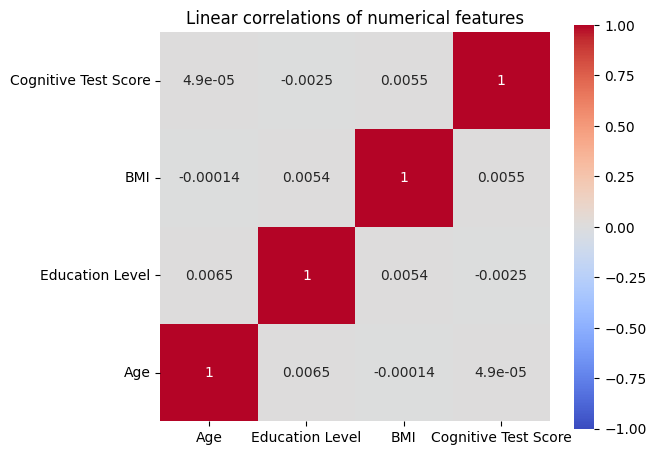

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(alzheimers.select_dtypes(include='number').corr().iloc[::-1], vmin=-1, vmax=1, cmap='coolwarm', annot=True, square=True)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.title("Linear correlations of numerical features")
plt.tight_layout()
plt.show()

# Preprocessing

In [3]:
from preprocessing import alzheimers_preprocessing

alzheimers_encoded = alzheimers_preprocessing(alzheimers)

Saving to CSV

In [ ]:
alzheimers_encoded.to_csv("data/alzheimers_encoded.csv", index=False)

# Modeling

### Feature Selection

In [29]:
import pandas as pd

alzheimers = pd.read_csv("data/alzheimers.csv")
alzheimers_encoded = pd.read_csv("data/alzheimers_encoded.csv")

feature_names = alzheimers_encoded.columns
numerical_data = alzheimers_encoded.drop(columns=["Alzheimers_Diagnosis_Yes"])
target = alzheimers_encoded['Alzheimers_Diagnosis_Yes']

Helper timer decorator

In [30]:
import time
from functools import wraps

def time_it():
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            start = time.perf_counter()
            result = func(*args, **kwargs)
            end = time.perf_counter()
            print(f"[TIMER] {func.__name__} took {end - start:.4f} seconds")
            return result
        return wrapper
    return decorator

### CV Strategy

In [31]:
from sklearn.model_selection import train_test_split, KFold
import numpy as np
from sklearn.model_selection import cross_validate

# def evaluate(X, y, model):
#     predictions = model.predict(X, y)
#     accuracy = np.sum(predictions == y) / predictions.__len__()
#     return accuracy

# def basic_tt_split_validation(X, y, model, train_size = 0.80):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = train_size)
#     model.fit(X_train, y_train)
#     return evaluate(X_test, y_test, model)

# def kfold_tt_split_validation(X, y, model, n_splits = 5):
#     kf = KFold(n_splits = n_splits, shuffle = True)
#     metrics = []
#     for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
#         X_train, X_test, y_train, y_test = X[train_idx], X[test_idx], y[train_idx], y[test_idx]
#         model.fit(X_train, y_train)
#         metrics.append(evaluate(X_test, y_test, model))
#     return metrics

@time_it()
def evaluate_model(estimator, X, y, cv):
    scoring = ["accuracy", "precision_macro", "recall_macro", "f1_macro"]
    cv_results = cross_validate(estimator, X, y, scoring=scoring, cv=cv, n_jobs=-1)

    metrics = {
        "accuracy": np.mean(cv_results["test_accuracy"]),
        "precision": np.mean(cv_results["test_precision_macro"]),
        "recall": np.mean(cv_results["test_recall_macro"]),
        "f1": np.mean(cv_results["test_f1_macro"]),
    }
    return metrics

### Benchmarking

In [32]:
predictions = alzheimers_encoded['Age'] > 0
(predictions.values == alzheimers_encoded['Alzheimers_Diagnosis_Yes']).sum() / alzheimers_encoded.__len__()

np.float64(0.6949369303878411)

Benchmark model has a 69.49% accuracy.

### Modeling and Results

In [33]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1337)

estimators = {
    "LogisticRegression": LogisticRegression(),
    "RandomForest": RandomForestClassifier(),
    "XGBoost": xgb.XGBClassifier(eval_metric="logloss"),
    "NaiveBayes": GaussianNB(),
    "LDA": LinearDiscriminantAnalysis(),
    "QDA": QuadraticDiscriminantAnalysis(),
    "KNN": KNeighborsClassifier(),
    "SVM": LinearSVC(C=1.0)
}

results = {}

for name, model in estimators.items():
    print(f"Running {name} evaluation:")
    metrics = evaluate_model(model, numerical_data, target, skf)
    results[name] = metrics

for name, metrics_dict in results.items():
    print(f"\n{name} Metrics:")
    for metric_name, metric_val in metrics_dict.items():
        print(f"\t{metric_name}: {metric_val:.4f}")

Running LogisticRegression evaluation:
[TIMER] evaluate_model took 3.5210 seconds
Running RandomForest evaluation:
[TIMER] evaluate_model took 14.3057 seconds
Running XGBoost evaluation:
[TIMER] evaluate_model took 1.6745 seconds
Running NaiveBayes evaluation:
[TIMER] evaluate_model took 0.4176 seconds
Running LDA evaluation:
[TIMER] evaluate_model took 1.6985 seconds
Running QDA evaluation:
[TIMER] evaluate_model took 1.3968 seconds
Running KNN evaluation:
[TIMER] evaluate_model took 6.7685 seconds
Running SVM evaluation:
[TIMER] evaluate_model took 1.0092 seconds

LogisticRegression Metrics:
	accuracy: 0.7149
	precision: 0.7061
	recall: 0.6992
	f1: 0.7015

RandomForest Metrics:
	accuracy: 0.7209
	precision: 0.7121
	recall: 0.7084
	f1: 0.7099

XGBoost Metrics:
	accuracy: 0.7148
	precision: 0.7058
	recall: 0.7047
	f1: 0.7052

NaiveBayes Metrics:
	accuracy: 0.6377
	precision: 0.6251
	recall: 0.6234
	f1: 0.6240

LDA Metrics:
	accuracy: 0.7154
	precision: 0.7065
	recall: 0.7006
	f1: 0.702

# Feature Importances

Only some models have `feature_importances_` or `coef_`, the most straightforward metrics for feature importance. We will only be doing feature importance analysis on those models that have such attributes:

In [36]:
def get_feature_importances(model, feature_names):
    # Tree based models usually have a feature_importances_ attribute
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        return list(zip(feature_names, importances))

    # Linear models usually have a coef_ attribute
    elif hasattr(model, "coef_"):
        coef = model.coef_
        importances = np.abs(coef[0])

        return list(zip(feature_names, importances))
    else:
        return None


def run_feature_importance_analysis(num_importances=5):
    fitted_models = {}
    for name, model in estimators.items():
        print(f"Fitting {name} ...")
        model.fit(numerical_data, target)
        fitted_models[name] = model

    for name, model in fitted_models.items():
        importances = get_feature_importances(model, feature_names)
        if importances is not None:
            print(f"\n{name} feature importances:")
            for feat, val in sorted(importances, key=lambda x: x[1], reverse=True)[:5]:
                print(f"\t{feat}: {val:.4f}")
        else:
            print(f"\n{name} does not provide a direct feature importance measure.")

run_feature_importance_analysis()

Fitting LogisticRegression ...
Fitting RandomForest ...
Fitting XGBoost ...
Fitting NaiveBayes ...
Fitting LDA ...
Fitting QDA ...
Fitting KNN ...
Fitting SVM ...

LogisticRegression feature importances:
	Genetic_Risk_Factor_(APOE-ε4_allele)_Yes: 1.2644
	Age: 1.0653
	Family_History_of_Alzheimers_Yes: 0.8254
	Country_Russia: 0.5904
	Country_India: 0.5464

RandomForest feature importances:
	Age: 0.2491
	BMI: 0.0825
	Cognitive_Test_Score: 0.0781
	Education_Level: 0.0644
	Genetic_Risk_Factor_(APOE-ε4_allele)_Yes: 0.0365

XGBoost feature importances:
	Genetic_Risk_Factor_(APOE-ε4_allele)_Yes: 0.2010
	Age: 0.1338
	Family_History_of_Alzheimers_Yes: 0.0960
	Country_South_Africa: 0.0249
	Country_Russia: 0.0246

NaiveBayes does not provide a direct feature importance measure.

LDA feature importances:
	Genetic_Risk_Factor_(APOE-ε4_allele)_Yes: 1.3064
	Age: 1.1303
	Family_History_of_Alzheimers_Yes: 0.8412
	Country_Russia: 0.5974
	Country_India: 0.5563

QDA does not provide a direct feature import

Fitting RandomForest ...
Finished fitting


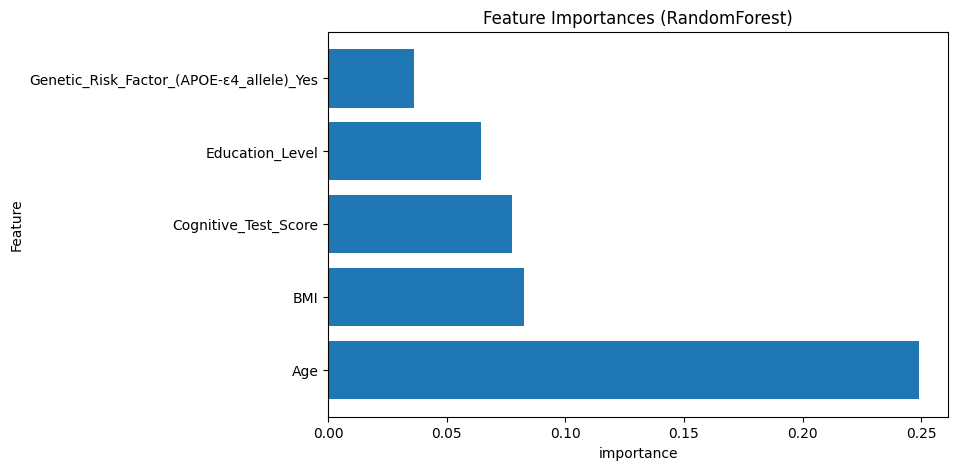

[('Age', np.float64(0.24895059285485835)),
 ('BMI', np.float64(0.08266007773724944)),
 ('Cognitive_Test_Score', np.float64(0.0776615356799639)),
 ('Education_Level', np.float64(0.06437029272650922)),
 ('Genetic_Risk_Factor_(APOE-ε4_allele)_Yes',
  np.float64(0.036403268806509265))]

In [ ]:
import matplotlib.pyplot as plt
def plot_feature_importance(model_name, data, target, num_importances = 5):
    if model_name in estimators.keys():
        print(f"Fitting {model_name} ...")
        model = estimators[model_name]        
        model.fit(data, target)
        print("Finished fitting")
        importances = get_feature_importances(model, numerical_data.columns)
        sorted_importances = sorted(importances, key=lambda x: x[1], reverse=True)
        top_importances = sorted_importances[:num_importances]
        # Separate names and values for plotting
        labels = [t[0] for t in top_importances]
        values = [t[1] for t in top_importances]
        
        # Create a bar plot
        plt.figure(figsize=(8, 5))
        plt.barh(range(len(values)), values)
        plt.yticks(range(len(values)), labels)
        plt.title(f"Feature Importances ({model_name})")
        plt.xlabel("importance")
        plt.ylabel("Feature")
        plt.show()
        return sorted_importances

plot_feature_importance("RandomForest", numerical_data, target)

# Interaction Features

In [61]:
from sklearn.preprocessing import PolynomialFeatures

def get_interaction_feature_df() -> pd.DataFrame:
    poly = PolynomialFeatures(degree = 2, interaction_only = True, include_bias = False)
    interaction_data = poly.fit_transform(numerical_data, target)
    interaction_data_names = poly.get_feature_names_out(numerical_data.columns)
    interaction_data_df = pd.DataFrame(interaction_data, columns = interaction_data_names)
    return interaction_data_df
interaction_data = get_interaction_feature_df()

### Correlation Analysis

In [63]:
alzheimers_diagnosis_correlation = interaction_data.corrwith(target)
alzheimers_diagnosis_correlation.sort_values(ascending = False, key = abs).to_csv('cache/interaction_correlation.csv', header = "Coefficient", index_label = "Feature_Pair")

c:\HW\Spring_2025_MSU\STT811\PROJ\ALZ_PROJ\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning:

invalid value encountered in divide

c:\HW\Spring_2025_MSU\STT811\PROJ\ALZ_PROJ\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning:

invalid value encountered in divide



### Modeling

Fitting RandomForest ...
Finished fitting


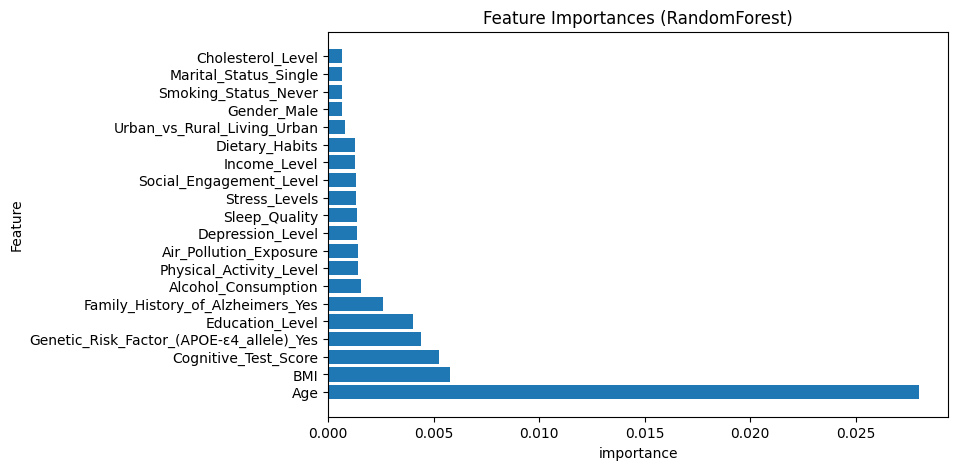

In [56]:
# evaluate_model(estimator=estimators["XGBoost"], X=interaction_data, y=target, cv = skf)
rf_interaction_imp = plot_feature_importance("RandomForest", interaction_data, target, 20)
rf_interaction_imp_df = pd.DataFrame(rf_interaction_imp, columns = ['Feature', 'Importance'])
rf_interaction_imp_df.to_csv('cache/randomforest_interaction_importances.csv', index=False)

Fitting LogisticRegression ...
Finished fitting


c:\HW\Spring_2025_MSU\STT811\PROJ\ALZ_PROJ\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



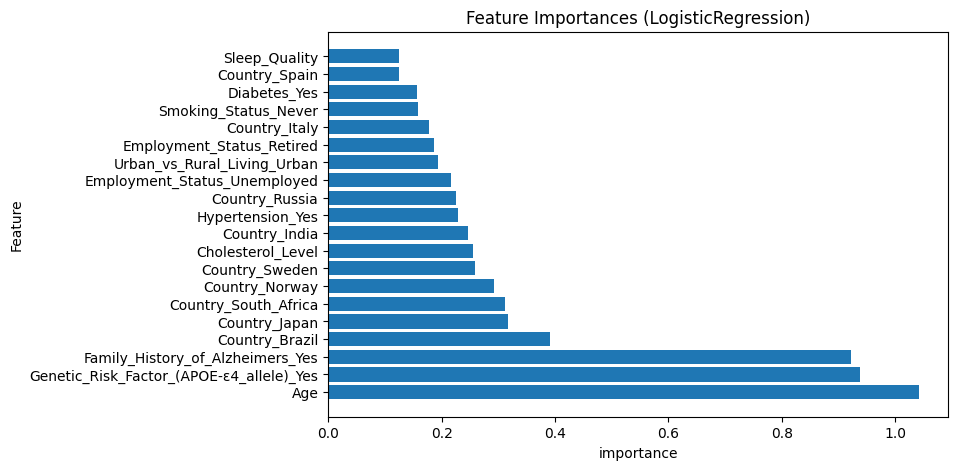

In [57]:
lr_interaction_imp = plot_feature_importance("LogisticRegression", interaction_data, target, 20)
lr_interaction_imp_df = pd.DataFrame(lr_interaction_imp, columns = ['Feature', 'Importance'])
lr_interaction_imp_df.to_csv('cache/logisticregression_interaction_importances.csv', index=False)

Fitting LDA ...
Finished fitting


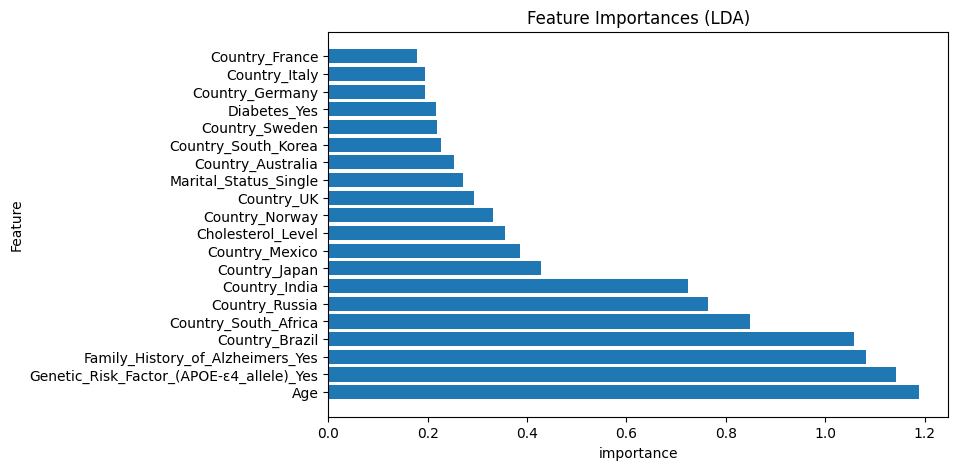

In [58]:
lda_interaction_imp = plot_feature_importance("LDA", interaction_data, target, 20)
lda_interaction_imp_df = pd.DataFrame(lda_interaction_imp, columns = ['Feature', 'Importance'])
lda_interaction_imp_df.to_csv('cache/lda_interaction_importances.csv', index=False)

Fitting SVM ...
Finished fitting


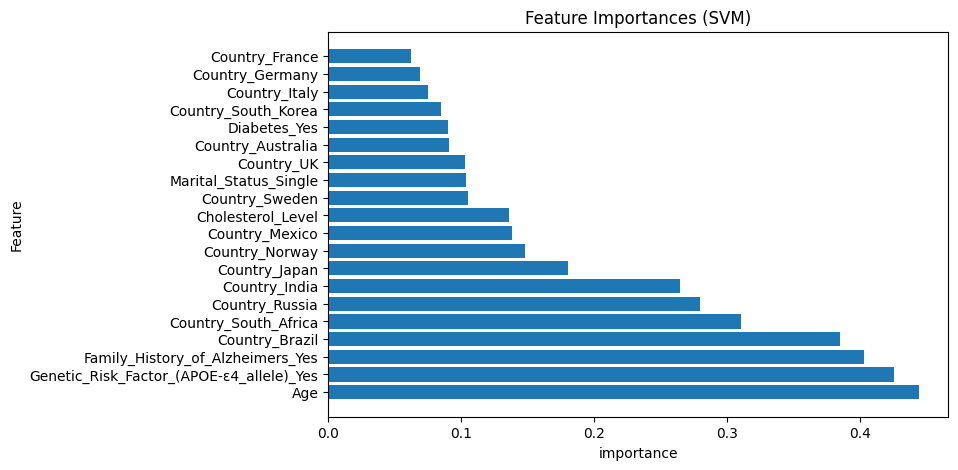

In [59]:
svm_interaction_imp = plot_feature_importance("SVM", interaction_data, target, 20)
svm_interaction_imp_df = pd.DataFrame(svm_interaction_imp, columns = ['Feature', 'Importance'])
svm_interaction_imp_df.to_csv('cache/svm_interaction_importances.csv', index=False)

Fitting XGBoost ...
Finished fitting


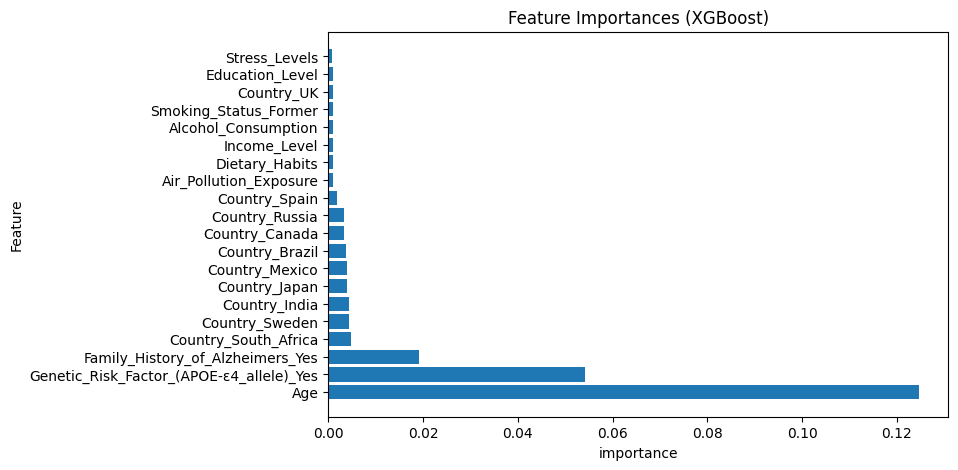

In [60]:
xgb_interaction_imp = plot_feature_importance("XGBoost", interaction_data, target, 20)
xgb_interaction_imp_df = pd.DataFrame(xgb_interaction_imp, columns = ['Feature', 'Importance'])
xgb_interaction_imp_df.to_csv('cache/xgboost_interaction_importances.csv', index=False)

Results

In [52]:
estimators = {
    "LogisticRegression": LogisticRegression(),
    "RandomForest": RandomForestClassifier(),
    "XGBoost": xgb.XGBClassifier(eval_metric="logloss"),
    "NaiveBayes": GaussianNB(),
    "LDA": LinearDiscriminantAnalysis(),
    "QDA": QuadraticDiscriminantAnalysis(),
    "KNN": KNeighborsClassifier(),
    "SVM": LinearSVC(C=1.0)
}

results = {}

for name, model in estimators.items():
    print(f"Running {name} evaluation:")
    metrics = evaluate_model(model, interaction_data, target, skf)
    results[name] = metrics

for name, metrics_dict in results.items():
    print(f"\n{name} Metrics:")
    for metric_name, metric_val in metrics_dict.items():
        print(f"\t{metric_name}: {metric_val:.4f}")

Running LogisticRegression evaluation:
[TIMER] evaluate_model took 43.7638 seconds
Running RandomForest evaluation:
[TIMER] evaluate_model took 98.7201 seconds
Running XGBoost evaluation:
[TIMER] evaluate_model took 18.1767 seconds
Running NaiveBayes evaluation:
[TIMER] evaluate_model took 8.0012 seconds
Running LDA evaluation:
[TIMER] evaluate_model took 71.1841 seconds
Running QDA evaluation:
[TIMER] evaluate_model took 59.7667 seconds
Running KNN evaluation:
[TIMER] evaluate_model took 65.0875 seconds
Running SVM evaluation:
[TIMER] evaluate_model took 61.8556 seconds

LogisticRegression Metrics:
	accuracy: 0.7117
	precision: 0.7026
	recall: 0.6968
	f1: 0.6988

RandomForest Metrics:
	accuracy: 0.7196
	precision: 0.7109
	recall: 0.7100
	f1: 0.7104

XGBoost Metrics:
	accuracy: 0.7148
	precision: 0.7058
	recall: 0.7047
	f1: 0.7052

NaiveBayes Metrics:
	accuracy: 0.6182
	precision: 0.6061
	recall: 0.6058
	f1: 0.6059

LDA Metrics:
	accuracy: 0.7126
	precision: 0.7036
	recall: 0.6973
	f1:

In [55]:
df = pd.DataFrame.from_dict(results, orient="index")
df.index.name = "Model"
df.reset_index(inplace=True)

df = df[["Model", "accuracy", "precision", "recall", "f1"]]
df[["accuracy", "precision", "recall", "f1"]] = df[["accuracy", "precision", "recall", "f1"]].round(4)

df.to_csv("cache/model_metrics.csv", index=False)
print("Saved to model_metrics.csv")

Saved to model_metrics.csv


# Hypertuning

In [ ]:
import optuna
from optuna import Trial
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

def objective(trial: Trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'verbosity': 0,
        'booster': 'gbtree',
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log = True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log = True),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.1, log = True),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log = True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }   


    xgboost = xgb.XGBClassifier(**params)
    pipe = Pipeline(steps=[
        ('smote', SMOTE(k_neighbors=5, random_state=42)),
        ('model', xgboost)
    ])
    metrics = evaluate_model(pipe, numerical_data, target, skf)
    return metrics['f1']

study = optuna.create_study(direction='maximize')

study.optimize(objective, show_progress_bar = True, n_trials=100)
print("Best Parameters: ", study.best_params)
print("Best Score: ", study.best_value)


[I 2025-04-19 23:49:52,170] A new study created in memory with name: no-name-451eba88-7149-449d-b998-a6973230f655
Best trial: 0. Best value: 0.564791:   1%|          | 1/100 [00:11<18:48, 11.40s/it]

[TIMER] evaluate_model took 11.3937 seconds
[I 2025-04-19 23:50:03,568] Trial 0 finished with value: 0.5647909284825123 and parameters: {'lambda': 0.11454353292611286, 'alpha': 0.0031119025905331434, 'max_depth': 9, 'eta': 0.012351019733445453, 'gamma': 5.874062790124933e-05, 'colsample_bytree': 0.1421137165629518, 'min_child_weight': 8}. Best is trial 0 with value: 0.5647909284825123.


Best trial: 1. Best value: 0.718873:   2%|▏         | 2/100 [00:23<19:02, 11.66s/it]

[TIMER] evaluate_model took 11.8331 seconds
[I 2025-04-19 23:50:15,410] Trial 1 finished with value: 0.7188725890796959 and parameters: {'lambda': 0.04585286768281725, 'alpha': 0.0011920725690125215, 'max_depth': 8, 'eta': 0.07892120856522386, 'gamma': 0.012981276516987926, 'colsample_bytree': 0.5159860719387466, 'min_child_weight': 7}. Best is trial 1 with value: 0.7188725890796959.


Best trial: 2. Best value: 0.720905:   3%|▎         | 3/100 [00:35<19:31, 12.07s/it]

[TIMER] evaluate_model took 12.5470 seconds
[I 2025-04-19 23:50:27,977] Trial 2 finished with value: 0.7209046827435321 and parameters: {'lambda': 0.010415438383908508, 'alpha': 0.07131933202181442, 'max_depth': 8, 'eta': 0.029008156639996292, 'gamma': 1.849393123540984e-06, 'colsample_bytree': 0.405699574221135, 'min_child_weight': 6}. Best is trial 2 with value: 0.7209046827435321.


Best trial: 3. Best value: 0.721846:   4%|▍         | 4/100 [00:47<18:51, 11.78s/it]

[TIMER] evaluate_model took 11.3340 seconds
[I 2025-04-19 23:50:39,319] Trial 3 finished with value: 0.7218462682427437 and parameters: {'lambda': 0.0014129007608520555, 'alpha': 0.007078009964783358, 'max_depth': 7, 'eta': 0.04013118213111262, 'gamma': 3.719932985679546e-07, 'colsample_bytree': 0.7790067914816494, 'min_child_weight': 8}. Best is trial 3 with value: 0.7218462682427437.


Best trial: 4. Best value: 0.722062:   5%|▌         | 5/100 [00:56<17:28, 11.04s/it]

[TIMER] evaluate_model took 9.7025 seconds
[I 2025-04-19 23:50:49,028] Trial 4 finished with value: 0.7220617718207478 and parameters: {'lambda': 0.06411753028984897, 'alpha': 6.106396160829238, 'max_depth': 7, 'eta': 0.021182351775115495, 'gamma': 1.1905359313019977e-08, 'colsample_bytree': 0.5109790502681171, 'min_child_weight': 10}. Best is trial 4 with value: 0.7220617718207478.


Best trial: 5. Best value: 0.723002:   6%|▌         | 6/100 [01:05<15:53, 10.15s/it]

[TIMER] evaluate_model took 8.4102 seconds
[I 2025-04-19 23:50:57,447] Trial 5 finished with value: 0.7230024191431553 and parameters: {'lambda': 0.14638944162734352, 'alpha': 0.008958928874356821, 'max_depth': 3, 'eta': 0.03328789867488881, 'gamma': 0.0018922456333704707, 'colsample_bytree': 0.8913985872572134, 'min_child_weight': 1}. Best is trial 5 with value: 0.7230024191431553.


Best trial: 5. Best value: 0.723002:   7%|▋         | 7/100 [01:13<14:31,  9.37s/it]

[TIMER] evaluate_model took 7.7555 seconds
[I 2025-04-19 23:51:05,212] Trial 6 finished with value: 0.7154566875027785 and parameters: {'lambda': 0.436382360751682, 'alpha': 2.268087993232393, 'max_depth': 3, 'eta': 0.01934503238442217, 'gamma': 2.212270295897692e-06, 'colsample_bytree': 0.16827461801179966, 'min_child_weight': 5}. Best is trial 5 with value: 0.7230024191431553.


Best trial: 5. Best value: 0.723002:   8%|▊         | 8/100 [01:22<14:29,  9.45s/it]

[TIMER] evaluate_model took 9.6333 seconds
[I 2025-04-19 23:51:14,853] Trial 7 finished with value: 0.7144849427502227 and parameters: {'lambda': 0.9506572552357974, 'alpha': 0.6383585658994126, 'max_depth': 7, 'eta': 0.029029632214270903, 'gamma': 1.2149751449486887e-07, 'colsample_bytree': 0.25670031474405786, 'min_child_weight': 2}. Best is trial 5 with value: 0.7230024191431553.


Best trial: 5. Best value: 0.723002:   9%|▉         | 9/100 [01:35<16:05, 10.61s/it]

[TIMER] evaluate_model took 13.1318 seconds
[I 2025-04-19 23:51:27,992] Trial 8 finished with value: 0.7194651974864904 and parameters: {'lambda': 0.011330992782356013, 'alpha': 0.003070536877564466, 'max_depth': 9, 'eta': 0.014839866846345905, 'gamma': 3.4556577587610334e-06, 'colsample_bytree': 0.43158719351349284, 'min_child_weight': 1}. Best is trial 5 with value: 0.7230024191431553.


Best trial: 9. Best value: 0.723132:  10%|█         | 10/100 [01:44<15:02, 10.03s/it]

[TIMER] evaluate_model took 8.7355 seconds
[I 2025-04-19 23:51:36,735] Trial 9 finished with value: 0.7231318053927616 and parameters: {'lambda': 0.0053589993784582, 'alpha': 3.264829990437927, 'max_depth': 4, 'eta': 0.03312841029247678, 'gamma': 0.00015250198363421657, 'colsample_bytree': 0.6558432005622575, 'min_child_weight': 6}. Best is trial 9 with value: 0.7231318053927616.


Best trial: 9. Best value: 0.723132:  11%|█         | 11/100 [01:53<14:27,  9.74s/it]

[TIMER] evaluate_model took 9.0609 seconds
[I 2025-04-19 23:51:45,823] Trial 10 finished with value: 0.7225246654210424 and parameters: {'lambda': 7.12743870775231, 'alpha': 0.24920184350473734, 'max_depth': 5, 'eta': 0.06446253397119713, 'gamma': 0.44356892283153054, 'colsample_bytree': 0.708725231697652, 'min_child_weight': 4}. Best is trial 9 with value: 0.7231318053927616.


Best trial: 11. Best value: 0.723208:  12%|█▏        | 12/100 [02:01<13:36,  9.28s/it]

[TIMER] evaluate_model took 8.1872 seconds
[I 2025-04-19 23:51:54,043] Trial 11 finished with value: 0.7232075785327851 and parameters: {'lambda': 0.0023695503714480236, 'alpha': 0.03183716932044879, 'max_depth': 3, 'eta': 0.048648522118469074, 'gamma': 0.0013055796211784852, 'colsample_bytree': 0.9489244238386471, 'min_child_weight': 3}. Best is trial 11 with value: 0.7232075785327851.


Best trial: 11. Best value: 0.723208:  13%|█▎        | 13/100 [02:10<13:12,  9.11s/it]

[TIMER] evaluate_model took 8.6856 seconds
[I 2025-04-19 23:52:02,758] Trial 12 finished with value: 0.7231547217023453 and parameters: {'lambda': 0.0010470595668438897, 'alpha': 0.03766249888214206, 'max_depth': 4, 'eta': 0.05096598313975437, 'gamma': 0.00034983428112998077, 'colsample_bytree': 0.96592162372765, 'min_child_weight': 3}. Best is trial 11 with value: 0.7232075785327851.


Best trial: 11. Best value: 0.723208:  14%|█▍        | 14/100 [02:19<13:10,  9.19s/it]

[TIMER] evaluate_model took 9.3491 seconds
[I 2025-04-19 23:52:12,133] Trial 13 finished with value: 0.7226560356333319 and parameters: {'lambda': 0.001079390137523988, 'alpha': 0.03250261069362135, 'max_depth': 5, 'eta': 0.056056077084514606, 'gamma': 0.009366716307600895, 'colsample_bytree': 0.9891751060767219, 'min_child_weight': 3}. Best is trial 11 with value: 0.7232075785327851.


Best trial: 11. Best value: 0.723208:  15%|█▌        | 15/100 [02:28<12:50,  9.06s/it]

[TIMER] evaluate_model took 8.7370 seconds
[I 2025-04-19 23:52:20,900] Trial 14 finished with value: 0.7227797199405162 and parameters: {'lambda': 0.0034589652175851617, 'alpha': 0.028576342313966697, 'max_depth': 4, 'eta': 0.05007574681436941, 'gamma': 0.00017142536785055455, 'colsample_bytree': 0.9633805451955022, 'min_child_weight': 3}. Best is trial 11 with value: 0.7232075785327851.


Best trial: 11. Best value: 0.723208:  16%|█▌        | 16/100 [02:37<12:27,  8.90s/it]

[TIMER] evaluate_model took 8.4769 seconds
[I 2025-04-19 23:52:29,411] Trial 15 finished with value: 0.7223434843443435 and parameters: {'lambda': 0.019577002137117126, 'alpha': 0.20427304350210088, 'max_depth': 4, 'eta': 0.07823631899926567, 'gamma': 0.4063250036063969, 'colsample_bytree': 0.8205192258057833, 'min_child_weight': 4}. Best is trial 11 with value: 0.7232075785327851.


Best trial: 11. Best value: 0.723208:  17%|█▋        | 17/100 [02:46<12:39,  9.15s/it]

[TIMER] evaluate_model took 9.7131 seconds
[I 2025-04-19 23:52:39,162] Trial 16 finished with value: 0.7224259452339762 and parameters: {'lambda': 0.002390073249317345, 'alpha': 0.02709340198245872, 'max_depth': 5, 'eta': 0.04496193520759652, 'gamma': 0.0014767624092302807, 'colsample_bytree': 0.8827670266070158, 'min_child_weight': 3}. Best is trial 11 with value: 0.7232075785327851.


Best trial: 11. Best value: 0.723208:  18%|█▊        | 18/100 [02:55<12:03,  8.82s/it]

[TIMER] evaluate_model took 8.0243 seconds
[I 2025-04-19 23:52:47,217] Trial 17 finished with value: 0.7227264752167886 and parameters: {'lambda': 0.0010641149333883802, 'alpha': 0.08156289277182471, 'max_depth': 3, 'eta': 0.094531826934675, 'gamma': 2.520620411383241e-05, 'colsample_bytree': 0.6436774537542578, 'min_child_weight': 2}. Best is trial 11 with value: 0.7232075785327851.


Best trial: 11. Best value: 0.723208:  19%|█▉        | 19/100 [03:05<12:28,  9.24s/it]

[TIMER] evaluate_model took 10.1831 seconds
[I 2025-04-19 23:52:57,430] Trial 18 finished with value: 0.7222797234809007 and parameters: {'lambda': 0.0050786189051539215, 'alpha': 0.4687363978320901, 'max_depth': 6, 'eta': 0.0633500319416216, 'gamma': 0.036817708012801584, 'colsample_bytree': 0.9998797667986529, 'min_child_weight': 5}. Best is trial 11 with value: 0.7232075785327851.


Best trial: 11. Best value: 0.723208:  20%|██        | 20/100 [03:14<12:09,  9.12s/it]

[TIMER] evaluate_model took 8.8051 seconds
[I 2025-04-19 23:53:06,265] Trial 19 finished with value: 0.7231386213798459 and parameters: {'lambda': 9.159481383167423, 'alpha': 0.012240263823217915, 'max_depth': 4, 'eta': 0.04075174655266041, 'gamma': 0.0007910889871403163, 'colsample_bytree': 0.8322859366055539, 'min_child_weight': 4}. Best is trial 11 with value: 0.7232075785327851.


Best trial: 11. Best value: 0.723208:  21%|██        | 21/100 [03:22<11:33,  8.78s/it]

[TIMER] evaluate_model took 7.9747 seconds
[I 2025-04-19 23:53:14,269] Trial 20 finished with value: 0.7229269748914469 and parameters: {'lambda': 0.020920348425209456, 'alpha': 0.13200005630854936, 'max_depth': 3, 'eta': 0.09846729278740782, 'gamma': 0.04286207248608251, 'colsample_bytree': 0.703235350045675, 'min_child_weight': 2}. Best is trial 11 with value: 0.7232075785327851.


Best trial: 11. Best value: 0.723208:  22%|██▏       | 22/100 [03:30<11:25,  8.79s/it]

[TIMER] evaluate_model took 8.7688 seconds
[I 2025-04-19 23:53:23,075] Trial 21 finished with value: 0.7228907805381966 and parameters: {'lambda': 7.377713102714643, 'alpha': 0.009745905196321087, 'max_depth': 4, 'eta': 0.04524581903381559, 'gamma': 0.0007860329031831139, 'colsample_bytree': 0.8634680957722484, 'min_child_weight': 4}. Best is trial 11 with value: 0.7232075785327851.


Best trial: 11. Best value: 0.723208:  23%|██▎       | 23/100 [03:39<11:19,  8.83s/it]

[TIMER] evaluate_model took 8.8810 seconds
[I 2025-04-19 23:53:31,988] Trial 22 finished with value: 0.722932695711484 and parameters: {'lambda': 1.4018240277840195, 'alpha': 0.020962529219634395, 'max_depth': 4, 'eta': 0.03895755991346912, 'gamma': 0.00038650257942206875, 'colsample_bytree': 0.9279468975542685, 'min_child_weight': 4}. Best is trial 11 with value: 0.7232075785327851.


Best trial: 11. Best value: 0.723208:  24%|██▍       | 24/100 [03:49<11:29,  9.07s/it]

[TIMER] evaluate_model took 9.6097 seconds
[I 2025-04-19 23:53:41,627] Trial 23 finished with value: 0.7229699918495875 and parameters: {'lambda': 0.25260528000947297, 'alpha': 0.013501946480688963, 'max_depth': 5, 'eta': 0.02373054242684741, 'gamma': 2.4690701467284302e-05, 'colsample_bytree': 0.7871641663242118, 'min_child_weight': 3}. Best is trial 11 with value: 0.7232075785327851.


Best trial: 11. Best value: 0.723208:  25%|██▌       | 25/100 [03:59<11:39,  9.33s/it]

[TIMER] evaluate_model took 9.8902 seconds
[I 2025-04-19 23:53:51,559] Trial 24 finished with value: 0.7223970166938426 and parameters: {'lambda': 2.7032772878815514, 'alpha': 0.056541127224601674, 'max_depth': 6, 'eta': 0.05570492322692601, 'gamma': 0.00420840031991356, 'colsample_bytree': 0.836978382275247, 'min_child_weight': 5}. Best is trial 11 with value: 0.7232075785327851.


Best trial: 25. Best value: 0.72328:  26%|██▌       | 26/100 [04:07<11:09,  9.05s/it] 

[TIMER] evaluate_model took 8.3604 seconds
[I 2025-04-19 23:53:59,952] Trial 25 finished with value: 0.7232796357563958 and parameters: {'lambda': 0.0023094688326579047, 'alpha': 0.0029521853900008267, 'max_depth': 3, 'eta': 0.03834607562300563, 'gamma': 1.3815385302807788e-05, 'colsample_bytree': 0.9228863268217726, 'min_child_weight': 2}. Best is trial 25 with value: 0.7232796357563958.


Best trial: 25. Best value: 0.72328:  27%|██▋       | 27/100 [04:16<10:47,  8.87s/it]

[TIMER] evaluate_model took 8.4166 seconds
[I 2025-04-19 23:54:08,405] Trial 26 finished with value: 0.7228636579491114 and parameters: {'lambda': 0.0024979664238124442, 'alpha': 0.0013201766711039395, 'max_depth': 3, 'eta': 0.02541183675837706, 'gamma': 1.2606988557299975e-05, 'colsample_bytree': 0.9278972231031495, 'min_child_weight': 1}. Best is trial 25 with value: 0.7232796357563958.


Best trial: 25. Best value: 0.72328:  28%|██▊       | 28/100 [04:24<10:31,  8.76s/it]

[TIMER] evaluate_model took 8.4822 seconds
[I 2025-04-19 23:54:16,924] Trial 27 finished with value: 0.7229726742516769 and parameters: {'lambda': 0.0082429794973503, 'alpha': 0.002589136994503407, 'max_depth': 3, 'eta': 0.03579036690218009, 'gamma': 9.229577052987388e-05, 'colsample_bytree': 0.7390191671978614, 'min_child_weight': 2}. Best is trial 25 with value: 0.7232796357563958.


Best trial: 28. Best value: 0.723502:  29%|██▉       | 29/100 [04:32<10:07,  8.56s/it]

[TIMER] evaluate_model took 8.0551 seconds
[I 2025-04-19 23:54:25,015] Trial 28 finished with value: 0.7235023960337684 and parameters: {'lambda': 0.0021282359284657973, 'alpha': 0.006127907978071487, 'max_depth': 3, 'eta': 0.069249219749247, 'gamma': 3.9128271489689835e-07, 'colsample_bytree': 0.5986342337414767, 'min_child_weight': 2}. Best is trial 28 with value: 0.7235023960337684.


Best trial: 28. Best value: 0.723502:  30%|███       | 30/100 [04:41<09:55,  8.51s/it]

[TIMER] evaluate_model took 8.3584 seconds
[I 2025-04-19 23:54:33,407] Trial 29 finished with value: 0.7221880079211235 and parameters: {'lambda': 0.027757781743279343, 'alpha': 0.0052192858036779685, 'max_depth': 3, 'eta': 0.010620414729642222, 'gamma': 1.8012474385336007e-07, 'colsample_bytree': 0.5981510534443728, 'min_child_weight': 1}. Best is trial 28 with value: 0.7235023960337684.


Best trial: 28. Best value: 0.723502:  31%|███       | 31/100 [04:49<09:41,  8.43s/it]

[TIMER] evaluate_model took 8.2122 seconds
[I 2025-04-19 23:54:41,660] Trial 30 finished with value: 0.7225385072314408 and parameters: {'lambda': 0.0024419130921269428, 'alpha': 0.004514568134918836, 'max_depth': 3, 'eta': 0.07146935089338127, 'gamma': 2.1697227202887977e-08, 'colsample_bytree': 0.3045234421644735, 'min_child_weight': 2}. Best is trial 28 with value: 0.7235023960337684.


Best trial: 28. Best value: 0.723502:  32%|███▏      | 32/100 [04:58<09:42,  8.56s/it]

[TIMER] evaluate_model took 8.8097 seconds
[I 2025-04-19 23:54:50,516] Trial 31 finished with value: 0.7229417650485954 and parameters: {'lambda': 0.0017528314703015777, 'alpha': 0.04898703911126869, 'max_depth': 4, 'eta': 0.05381322598071382, 'gamma': 6.862677471163978e-06, 'colsample_bytree': 0.9315835363647156, 'min_child_weight': 3}. Best is trial 28 with value: 0.7235023960337684.


Best trial: 28. Best value: 0.723502:  33%|███▎      | 33/100 [05:06<09:27,  8.47s/it]

[TIMER] evaluate_model took 8.2290 seconds
[I 2025-04-19 23:54:58,785] Trial 32 finished with value: 0.7229692656572134 and parameters: {'lambda': 0.005172395233387811, 'alpha': 0.0015772247579825505, 'max_depth': 3, 'eta': 0.04625536979954584, 'gamma': 3.960131910930669e-05, 'colsample_bytree': 0.9012236372560932, 'min_child_weight': 2}. Best is trial 28 with value: 0.7235023960337684.


Best trial: 28. Best value: 0.723502:  34%|███▍      | 34/100 [05:15<09:25,  8.56s/it]

[TIMER] evaluate_model took 8.7406 seconds
[I 2025-04-19 23:55:07,558] Trial 33 finished with value: 0.7228713700249123 and parameters: {'lambda': 0.0037852619071582056, 'alpha': 0.0027118419937504335, 'max_depth': 4, 'eta': 0.06313682708589059, 'gamma': 7.350285393741662e-07, 'colsample_bytree': 0.5593756326417336, 'min_child_weight': 3}. Best is trial 28 with value: 0.7235023960337684.


Best trial: 28. Best value: 0.723502:  35%|███▌      | 35/100 [05:23<09:05,  8.39s/it]

[TIMER] evaluate_model took 7.9457 seconds
[I 2025-04-19 23:55:15,535] Trial 34 finished with value: 0.7227542986004332 and parameters: {'lambda': 0.010847402026931482, 'alpha': 0.01704711632462156, 'max_depth': 3, 'eta': 0.08610242152570573, 'gamma': 6.421462035002077e-07, 'colsample_bytree': 0.7565643881600068, 'min_child_weight': 8}. Best is trial 28 with value: 0.7235023960337684.


Best trial: 28. Best value: 0.723502:  36%|███▌      | 36/100 [05:32<09:12,  8.63s/it]

[TIMER] evaluate_model took 9.1499 seconds
[I 2025-04-19 23:55:24,720] Trial 35 finished with value: 0.7228194727006774 and parameters: {'lambda': 0.001023017614786347, 'alpha': 0.005258405957184371, 'max_depth': 5, 'eta': 0.07328879822769238, 'gamma': 7.327717738353282e-08, 'colsample_bytree': 0.4057458670071561, 'min_child_weight': 7}. Best is trial 28 with value: 0.7235023960337684.


Best trial: 28. Best value: 0.723502:  37%|███▋      | 37/100 [05:41<09:05,  8.65s/it]

[TIMER] evaluate_model took 8.6798 seconds
[I 2025-04-19 23:55:33,429] Trial 36 finished with value: 0.722883030130626 and parameters: {'lambda': 0.0017686991813158806, 'alpha': 0.046873309412946686, 'max_depth': 4, 'eta': 0.05999368410533578, 'gamma': 0.00030652294633085243, 'colsample_bytree': 0.9535233320946137, 'min_child_weight': 10}. Best is trial 28 with value: 0.7235023960337684.


Best trial: 28. Best value: 0.723502:  38%|███▊      | 38/100 [05:52<09:49,  9.51s/it]

[TIMER] evaluate_model took 11.4953 seconds
[I 2025-04-19 23:55:44,957] Trial 37 finished with value: 0.7210006978637795 and parameters: {'lambda': 0.04990147768371006, 'alpha': 0.0017346656216731028, 'max_depth': 8, 'eta': 0.05056433173223817, 'gamma': 6.110890145475932e-06, 'colsample_bytree': 0.4567223946603532, 'min_child_weight': 1}. Best is trial 28 with value: 0.7235023960337684.


Best trial: 28. Best value: 0.723502:  39%|███▉      | 39/100 [06:00<09:11,  9.03s/it]

[TIMER] evaluate_model took 7.8721 seconds
[I 2025-04-19 23:55:52,874] Trial 38 finished with value: 0.7232499902707115 and parameters: {'lambda': 0.0088339743243646, 'alpha': 0.14345000030663638, 'max_depth': 3, 'eta': 0.03919012733051191, 'gamma': 0.004598922094088179, 'colsample_bytree': 0.3072194402333382, 'min_child_weight': 2}. Best is trial 28 with value: 0.7235023960337684.


Best trial: 28. Best value: 0.723502:  40%|████      | 40/100 [06:08<08:40,  8.68s/it]

[TIMER] evaluate_model took 7.8095 seconds
[I 2025-04-19 23:56:00,725] Trial 39 finished with value: 0.6641250452438912 and parameters: {'lambda': 0.007601454357725404, 'alpha': 0.13509630518764387, 'max_depth': 3, 'eta': 0.027876514235272855, 'gamma': 0.012304161063634496, 'colsample_bytree': 0.11774963032585384, 'min_child_weight': 1}. Best is trial 28 with value: 0.7235023960337684.


Best trial: 28. Best value: 0.723502:  41%|████      | 41/100 [06:16<08:21,  8.50s/it]

[TIMER] evaluate_model took 8.0444 seconds
[I 2025-04-19 23:56:08,815] Trial 40 finished with value: 0.7230201566274397 and parameters: {'lambda': 0.12655990688596924, 'alpha': 0.6283532092558957, 'max_depth': 3, 'eta': 0.03756850313150518, 'gamma': 0.07820485545777017, 'colsample_bytree': 0.34275246130943443, 'min_child_weight': 9}. Best is trial 28 with value: 0.7235023960337684.


Best trial: 28. Best value: 0.723502:  42%|████▏     | 42/100 [06:24<08:01,  8.31s/it]

[TIMER] evaluate_model took 7.8206 seconds
[I 2025-04-19 23:56:16,669] Trial 41 finished with value: 0.7212228982793423 and parameters: {'lambda': 0.0016609348946695487, 'alpha': 0.008336509006183865, 'max_depth': 3, 'eta': 0.03169384852126526, 'gamma': 0.0031360545319311568, 'colsample_bytree': 0.21365317842531134, 'min_child_weight': 2}. Best is trial 28 with value: 0.7235023960337684.


Best trial: 42. Best value: 0.723607:  43%|████▎     | 43/100 [06:32<07:53,  8.30s/it]

[TIMER] evaluate_model took 8.2357 seconds
[I 2025-04-19 23:56:24,948] Trial 42 finished with value: 0.7236070945111642 and parameters: {'lambda': 0.003421544563491966, 'alpha': 0.31918732462692395, 'max_depth': 3, 'eta': 0.04166693292673297, 'gamma': 0.000524469907630062, 'colsample_bytree': 0.49085187895643473, 'min_child_weight': 2}. Best is trial 42 with value: 0.7236070945111642.


Best trial: 42. Best value: 0.723607:  44%|████▍     | 44/100 [06:41<07:44,  8.29s/it]

[TIMER] evaluate_model took 8.2340 seconds
[I 2025-04-19 23:56:33,220] Trial 43 finished with value: 0.7234217148486273 and parameters: {'lambda': 0.003337091545175654, 'alpha': 1.4675410515594152, 'max_depth': 3, 'eta': 0.04028904880315086, 'gamma': 0.004830471884063423, 'colsample_bytree': 0.4971382940517667, 'min_child_weight': 2}. Best is trial 42 with value: 0.7236070945111642.


Best trial: 42. Best value: 0.723607:  45%|████▌     | 45/100 [06:51<08:18,  9.06s/it]

[TIMER] evaluate_model took 10.8334 seconds
[I 2025-04-19 23:56:44,087] Trial 44 finished with value: 0.7202009484068748 and parameters: {'lambda': 0.014402623421346376, 'alpha': 1.4325349806311616, 'max_depth': 8, 'eta': 0.04216865885446127, 'gamma': 0.0042085356777397664, 'colsample_bytree': 0.3386614123855478, 'min_child_weight': 2}. Best is trial 42 with value: 0.7236070945111642.


Best trial: 42. Best value: 0.723607:  46%|████▌     | 46/100 [07:04<09:12, 10.23s/it]

[TIMER] evaluate_model took 12.8959 seconds
[I 2025-04-19 23:56:57,022] Trial 45 finished with value: 0.7204564690879469 and parameters: {'lambda': 0.0036527866957049094, 'alpha': 1.4376331116508894, 'max_depth': 9, 'eta': 0.03535600812664643, 'gamma': 1.3647494673059396e-06, 'colsample_bytree': 0.46064802776574143, 'min_child_weight': 1}. Best is trial 42 with value: 0.7236070945111642.


Best trial: 42. Best value: 0.723607:  47%|████▋     | 47/100 [07:15<09:01, 10.21s/it]

[TIMER] evaluate_model took 10.1506 seconds
[I 2025-04-19 23:57:07,209] Trial 46 finished with value: 0.7222657329735312 and parameters: {'lambda': 0.008108387657673698, 'alpha': 9.199015722096512, 'max_depth': 7, 'eta': 0.029207990340818363, 'gamma': 0.025725175997420625, 'colsample_bytree': 0.5312049273540146, 'min_child_weight': 2}. Best is trial 42 with value: 0.7236070945111642.


Best trial: 42. Best value: 0.723607:  48%|████▊     | 48/100 [07:23<08:21,  9.64s/it]

[TIMER] evaluate_model took 8.2681 seconds
[I 2025-04-19 23:57:15,509] Trial 47 finished with value: 0.722037610290472 and parameters: {'lambda': 0.07384084396973817, 'alpha': 0.32909565024792936, 'max_depth': 3, 'eta': 0.021543583210631784, 'gamma': 0.08545604509925334, 'colsample_bytree': 0.504392202202825, 'min_child_weight': 1}. Best is trial 42 with value: 0.7236070945111642.


Best trial: 42. Best value: 0.723607:  49%|████▉     | 49/100 [07:32<07:59,  9.41s/it]

[TIMER] evaluate_model took 8.8287 seconds
[I 2025-04-19 23:57:24,374] Trial 48 finished with value: 0.722986756848783 and parameters: {'lambda': 0.03356257773133619, 'alpha': 4.413525765568545, 'max_depth': 4, 'eta': 0.03212782454423112, 'gamma': 0.006525249514387447, 'colsample_bytree': 0.5890259920025045, 'min_child_weight': 2}. Best is trial 42 with value: 0.7236070945111642.


Best trial: 42. Best value: 0.723607:  50%|█████     | 50/100 [07:41<07:46,  9.34s/it]

[TIMER] evaluate_model took 9.1260 seconds
[I 2025-04-19 23:57:33,541] Trial 49 finished with value: 0.7216358302202619 and parameters: {'lambda': 0.005902953174504627, 'alpha': 0.9940280941716864, 'max_depth': 6, 'eta': 0.017276635858110713, 'gamma': 7.001238156701154e-05, 'colsample_bytree': 0.36733238262505347, 'min_child_weight': 6}. Best is trial 42 with value: 0.7236070945111642.


Best trial: 42. Best value: 0.723607:  51%|█████     | 51/100 [07:49<07:19,  8.97s/it]

[TIMER] evaluate_model took 8.0861 seconds
[I 2025-04-19 23:57:41,668] Trial 50 finished with value: 0.7221127134898728 and parameters: {'lambda': 0.0034036817148368932, 'alpha': 0.23247529865831917, 'max_depth': 3, 'eta': 0.04234384433345114, 'gamma': 3.647128695815053e-08, 'colsample_bytree': 0.25858482624759704, 'min_child_weight': 3}. Best is trial 42 with value: 0.7236070945111642.


Best trial: 51. Best value: 0.723734:  52%|█████▏    | 52/100 [07:57<07:00,  8.76s/it]

[TIMER] evaluate_model took 8.2068 seconds
[I 2025-04-19 23:57:49,918] Trial 51 finished with value: 0.7237336917739398 and parameters: {'lambda': 0.002429241242386683, 'alpha': 0.12321711741140169, 'max_depth': 3, 'eta': 0.04717367685175416, 'gamma': 0.0011761376002989731, 'colsample_bytree': 0.48804858893481196, 'min_child_weight': 3}. Best is trial 51 with value: 0.7237336917739398.


Best trial: 51. Best value: 0.723734:  53%|█████▎    | 53/100 [08:06<06:44,  8.62s/it]

[TIMER] evaluate_model took 8.2554 seconds
[I 2025-04-19 23:57:58,206] Trial 52 finished with value: 0.7234820843980562 and parameters: {'lambda': 0.0015655644291650958, 'alpha': 0.10404933113657433, 'max_depth': 3, 'eta': 0.037276542249196694, 'gamma': 0.0020319699089267193, 'colsample_bytree': 0.49498624028120575, 'min_child_weight': 2}. Best is trial 51 with value: 0.7237336917739398.


Best trial: 51. Best value: 0.723734:  54%|█████▍    | 54/100 [08:14<06:31,  8.51s/it]

[TIMER] evaluate_model took 8.2062 seconds
[I 2025-04-19 23:58:06,453] Trial 53 finished with value: 0.7232870689810449 and parameters: {'lambda': 0.0015567572265361492, 'alpha': 0.08529438760002343, 'max_depth': 3, 'eta': 0.02915982291995466, 'gamma': 0.0006558447940140041, 'colsample_bytree': 0.4914955507768248, 'min_child_weight': 1}. Best is trial 51 with value: 0.7237336917739398.


Best trial: 51. Best value: 0.723734:  55%|█████▌    | 55/100 [08:22<06:24,  8.55s/it]

[TIMER] evaluate_model took 8.6185 seconds
[I 2025-04-19 23:58:15,118] Trial 54 finished with value: 0.7235731293164792 and parameters: {'lambda': 0.001343079804460575, 'alpha': 0.08778194957401733, 'max_depth': 4, 'eta': 0.0357593176381605, 'gamma': 0.0006100824866357401, 'colsample_bytree': 0.4949039219883182, 'min_child_weight': 1}. Best is trial 51 with value: 0.7237336917739398.


Best trial: 51. Best value: 0.723734:  56%|█████▌    | 56/100 [08:31<06:21,  8.66s/it]

[TIMER] evaluate_model took 8.8779 seconds
[I 2025-04-19 23:58:24,028] Trial 55 finished with value: 0.7234624683577249 and parameters: {'lambda': 0.0013969656097439713, 'alpha': 0.4639067939769245, 'max_depth': 4, 'eta': 0.03410109838840204, 'gamma': 0.0018374821213104772, 'colsample_bytree': 0.6417921361302721, 'min_child_weight': 1}. Best is trial 51 with value: 0.7237336917739398.


Best trial: 51. Best value: 0.723734:  57%|█████▋    | 57/100 [08:40<06:14,  8.71s/it]

[TIMER] evaluate_model took 8.7924 seconds
[I 2025-04-19 23:58:32,860] Trial 56 finished with value: 0.7233338372249538 and parameters: {'lambda': 0.0016105910021586083, 'alpha': 0.32355444883640727, 'max_depth': 4, 'eta': 0.034507991403714286, 'gamma': 0.001991637116049406, 'colsample_bytree': 0.6523371791987883, 'min_child_weight': 1}. Best is trial 51 with value: 0.7237336917739398.


Best trial: 51. Best value: 0.723734:  58%|█████▊    | 58/100 [08:50<06:14,  8.92s/it]

[TIMER] evaluate_model took 9.3617 seconds
[I 2025-04-19 23:58:42,256] Trial 57 finished with value: 0.722928283062403 and parameters: {'lambda': 0.001230172322498209, 'alpha': 0.5003680617165961, 'max_depth': 5, 'eta': 0.02609333675830847, 'gamma': 0.00039117985340500537, 'colsample_bytree': 0.6097530955443864, 'min_child_weight': 1}. Best is trial 51 with value: 0.7237336917739398.


Best trial: 51. Best value: 0.723734:  59%|█████▉    | 59/100 [08:58<06:04,  8.89s/it]

[TIMER] evaluate_model took 8.7732 seconds
[I 2025-04-19 23:58:51,080] Trial 58 finished with value: 0.7234894195872071 and parameters: {'lambda': 0.0021902618780365105, 'alpha': 0.1928519528858583, 'max_depth': 4, 'eta': 0.044171643411916234, 'gamma': 0.0016269525141374707, 'colsample_bytree': 0.5595774748091658, 'min_child_weight': 3}. Best is trial 51 with value: 0.7237336917739398.


Best trial: 51. Best value: 0.723734:  60%|██████    | 60/100 [09:07<05:52,  8.82s/it]

[TIMER] evaluate_model took 8.6319 seconds
[I 2025-04-19 23:58:59,744] Trial 59 finished with value: 0.7232515010234751 and parameters: {'lambda': 0.0025318680786989554, 'alpha': 0.10580771060741309, 'max_depth': 4, 'eta': 0.047527250512787535, 'gamma': 0.00013035063523681272, 'colsample_bytree': 0.5513062392919893, 'min_child_weight': 4}. Best is trial 51 with value: 0.7237336917739398.


Best trial: 51. Best value: 0.723734:  61%|██████    | 61/100 [09:16<05:44,  8.82s/it]

[TIMER] evaluate_model took 8.7864 seconds
[I 2025-04-19 23:59:08,577] Trial 60 finished with value: 0.7224807967093326 and parameters: {'lambda': 0.004726730668464281, 'alpha': 0.16962309300056927, 'max_depth': 5, 'eta': 0.0676692154941598, 'gamma': 0.0010274323008720053, 'colsample_bytree': 0.41858762670415967, 'min_child_weight': 3}. Best is trial 51 with value: 0.7237336917739398.


Best trial: 51. Best value: 0.723734:  62%|██████▏   | 62/100 [09:25<05:34,  8.79s/it]

[TIMER] evaluate_model took 8.6768 seconds
[I 2025-04-19 23:59:17,287] Trial 61 finished with value: 0.7232698584774708 and parameters: {'lambda': 0.0021797209147545317, 'alpha': 0.3469243581187757, 'max_depth': 4, 'eta': 0.04355497017986722, 'gamma': 0.0020424128500939934, 'colsample_bytree': 0.45725434977122636, 'min_child_weight': 3}. Best is trial 51 with value: 0.7237336917739398.


Best trial: 51. Best value: 0.723734:  63%|██████▎   | 63/100 [09:34<05:27,  8.85s/it]

[TIMER] evaluate_model took 8.9441 seconds
[I 2025-04-19 23:59:26,268] Trial 62 finished with value: 0.7233995340540874 and parameters: {'lambda': 0.0014731599121965294, 'alpha': 0.06525101459440055, 'max_depth': 4, 'eta': 0.03594475746967554, 'gamma': 0.0001911896274228611, 'colsample_bytree': 0.6250598498269041, 'min_child_weight': 1}. Best is trial 51 with value: 0.7237336917739398.


Best trial: 51. Best value: 0.723734:  64%|██████▍   | 64/100 [09:42<05:18,  8.85s/it]

[TIMER] evaluate_model took 8.8096 seconds
[I 2025-04-19 23:59:35,119] Trial 63 finished with value: 0.7230918033125008 and parameters: {'lambda': 0.002974318076030956, 'alpha': 0.8635188204080056, 'max_depth': 4, 'eta': 0.05729857312003661, 'gamma': 0.0007205046464791699, 'colsample_bytree': 0.5748849577493204, 'min_child_weight': 2}. Best is trial 51 with value: 0.7237336917739398.


Best trial: 51. Best value: 0.723734:  65%|██████▌   | 65/100 [09:51<05:10,  8.88s/it]

[TIMER] evaluate_model took 8.9155 seconds
[I 2025-04-19 23:59:44,070] Trial 64 finished with value: 0.7231205798066624 and parameters: {'lambda': 0.001246408687276352, 'alpha': 0.2012706436845996, 'max_depth': 4, 'eta': 0.031075268783128173, 'gamma': 0.001810154387000842, 'colsample_bytree': 0.7008545279120304, 'min_child_weight': 3}. Best is trial 51 with value: 0.7237336917739398.


Best trial: 51. Best value: 0.723734:  66%|██████▌   | 66/100 [10:00<05:04,  8.94s/it]

[TIMER] evaluate_model took 9.0614 seconds
[I 2025-04-19 23:59:53,164] Trial 65 finished with value: 0.7228101647795159 and parameters: {'lambda': 0.0020653081370978067, 'alpha': 0.10082900501849813, 'max_depth': 5, 'eta': 0.05276068815335923, 'gamma': 0.019349491879639573, 'colsample_bytree': 0.5380999130149654, 'min_child_weight': 4}. Best is trial 51 with value: 0.7237336917739398.


Best trial: 51. Best value: 0.723734:  67%|██████▋   | 67/100 [10:09<04:48,  8.75s/it]

[TIMER] evaluate_model took 8.2729 seconds
[I 2025-04-20 00:00:01,478] Trial 66 finished with value: 0.7234392246029575 and parameters: {'lambda': 0.004391600343615395, 'alpha': 0.41773376353576, 'max_depth': 3, 'eta': 0.04796254755082846, 'gamma': 0.00023656508010617557, 'colsample_bytree': 0.6745006380015215, 'min_child_weight': 1}. Best is trial 51 with value: 0.7237336917739398.


Best trial: 51. Best value: 0.723734:  68%|██████▊   | 68/100 [10:17<04:38,  8.71s/it]

[TIMER] evaluate_model took 8.5794 seconds
[I 2025-04-20 00:00:10,094] Trial 67 finished with value: 0.7232420332712225 and parameters: {'lambda': 0.5156561364847948, 'alpha': 0.2676810378546152, 'max_depth': 4, 'eta': 0.03314846811960112, 'gamma': 0.0005573080588982737, 'colsample_bytree': 0.47743893573694196, 'min_child_weight': 2}. Best is trial 51 with value: 0.7237336917739398.


Best trial: 51. Best value: 0.723734:  69%|██████▉   | 69/100 [10:26<04:24,  8.53s/it]

[TIMER] evaluate_model took 8.0443 seconds
[I 2025-04-20 00:00:18,181] Trial 68 finished with value: 0.7234167974541147 and parameters: {'lambda': 0.006652253392576085, 'alpha': 0.765236973274364, 'max_depth': 3, 'eta': 0.08661369010910996, 'gamma': 0.008924172484867144, 'colsample_bytree': 0.5251017081786774, 'min_child_weight': 1}. Best is trial 51 with value: 0.7237336917739398.


Best trial: 51. Best value: 0.723734:  70%|███████   | 70/100 [10:35<04:21,  8.72s/it]

[TIMER] evaluate_model took 9.1354 seconds
[I 2025-04-20 00:00:27,354] Trial 69 finished with value: 0.7233410972129296 and parameters: {'lambda': 0.0010065626136241189, 'alpha': 0.16116657430411052, 'max_depth': 5, 'eta': 0.03688775786267442, 'gamma': 0.0012764344880760886, 'colsample_bytree': 0.5758044738638078, 'min_child_weight': 2}. Best is trial 51 with value: 0.7237336917739398.


Best trial: 51. Best value: 0.723734:  71%|███████   | 71/100 [10:43<04:08,  8.58s/it]

[TIMER] evaluate_model took 8.2092 seconds
[I 2025-04-20 00:00:35,598] Trial 70 finished with value: 0.7236453960067537 and parameters: {'lambda': 0.0027860477754355767, 'alpha': 0.03558976190742073, 'max_depth': 3, 'eta': 0.04450600299911112, 'gamma': 4.503378119389944e-05, 'colsample_bytree': 0.43964132058210525, 'min_child_weight': 4}. Best is trial 51 with value: 0.7237336917739398.


Best trial: 51. Best value: 0.723734:  72%|███████▏  | 72/100 [10:51<03:56,  8.46s/it]

[TIMER] evaluate_model took 8.1450 seconds
[I 2025-04-20 00:00:43,789] Trial 71 finished with value: 0.723733095623569 and parameters: {'lambda': 0.003070957662639697, 'alpha': 0.023238437491713712, 'max_depth': 3, 'eta': 0.04433469604638323, 'gamma': 4.279280123348776e-05, 'colsample_bytree': 0.442198834736455, 'min_child_weight': 4}. Best is trial 51 with value: 0.7237336917739398.


Best trial: 51. Best value: 0.723734:  73%|███████▎  | 73/100 [10:59<03:46,  8.38s/it]

[TIMER] evaluate_model took 8.1551 seconds
[I 2025-04-20 00:00:51,985] Trial 72 finished with value: 0.7234229631772082 and parameters: {'lambda': 0.0029353722506690037, 'alpha': 0.03855091836730253, 'max_depth': 3, 'eta': 0.04392617037514357, 'gamma': 2.963335360531641e-05, 'colsample_bytree': 0.38173076412412654, 'min_child_weight': 5}. Best is trial 51 with value: 0.7237336917739398.


Best trial: 51. Best value: 0.723734:  74%|███████▍  | 74/100 [11:07<03:36,  8.31s/it]

[TIMER] evaluate_model took 8.0992 seconds
[I 2025-04-20 00:01:00,128] Trial 73 finished with value: 0.7235452554028192 and parameters: {'lambda': 0.015063404848083009, 'alpha': 0.023867511263567565, 'max_depth': 3, 'eta': 0.051446494667198035, 'gamma': 5.703285032008681e-05, 'colsample_bytree': 0.4256413026837214, 'min_child_weight': 4}. Best is trial 51 with value: 0.7237336917739398.


Best trial: 51. Best value: 0.723734:  75%|███████▌  | 75/100 [11:16<03:27,  8.29s/it]

[TIMER] evaluate_model took 8.2155 seconds
[I 2025-04-20 00:01:08,378] Trial 74 finished with value: 0.7235470027375219 and parameters: {'lambda': 0.01712365233496705, 'alpha': 0.014656446415952628, 'max_depth': 3, 'eta': 0.05865276497970887, 'gamma': 8.069775686931354e-05, 'colsample_bytree': 0.43675560283245846, 'min_child_weight': 4}. Best is trial 51 with value: 0.7237336917739398.


Best trial: 51. Best value: 0.723734:  76%|███████▌  | 76/100 [11:24<03:18,  8.25s/it]

[TIMER] evaluate_model took 8.1180 seconds
[I 2025-04-20 00:01:16,534] Trial 75 finished with value: 0.72351472090621 and parameters: {'lambda': 0.014521327701225379, 'alpha': 0.022220374491793725, 'max_depth': 3, 'eta': 0.057732483302899984, 'gamma': 4.86551691849731e-05, 'colsample_bytree': 0.4309914726683347, 'min_child_weight': 5}. Best is trial 51 with value: 0.7237336917739398.


Best trial: 51. Best value: 0.723734:  77%|███████▋  | 77/100 [11:32<03:09,  8.23s/it]

[TIMER] evaluate_model took 8.1482 seconds
[I 2025-04-20 00:01:24,722] Trial 76 finished with value: 0.7235663939588944 and parameters: {'lambda': 0.01465284194458584, 'alpha': 0.02305043357921683, 'max_depth': 3, 'eta': 0.059138459819050616, 'gamma': 5.5126958583379835e-05, 'colsample_bytree': 0.4243957338356156, 'min_child_weight': 5}. Best is trial 51 with value: 0.7237336917739398.


Best trial: 51. Best value: 0.723734:  78%|███████▊  | 78/100 [11:40<03:00,  8.21s/it]

[TIMER] evaluate_model took 8.1367 seconds
[I 2025-04-20 00:01:32,897] Trial 77 finished with value: 0.7237212590968369 and parameters: {'lambda': 0.025692690508186743, 'alpha': 0.013607199139039503, 'max_depth': 3, 'eta': 0.051098572605663896, 'gamma': 8.962787510017119e-05, 'colsample_bytree': 0.3833707372906812, 'min_child_weight': 4}. Best is trial 51 with value: 0.7237336917739398.


Best trial: 51. Best value: 0.723734:  79%|███████▉  | 79/100 [11:48<02:52,  8.19s/it]

[TIMER] evaluate_model took 8.0954 seconds
[I 2025-04-20 00:01:41,033] Trial 78 finished with value: 0.7235538671935728 and parameters: {'lambda': 0.029589465942739736, 'alpha': 0.01202277451042714, 'max_depth': 3, 'eta': 0.06153013301495422, 'gamma': 1.2993423108560784e-05, 'colsample_bytree': 0.39355620638300354, 'min_child_weight': 6}. Best is trial 51 with value: 0.7237336917739398.


Best trial: 51. Best value: 0.723734:  80%|████████  | 80/100 [11:56<02:43,  8.16s/it]

[TIMER] evaluate_model took 8.0558 seconds
[I 2025-04-20 00:01:49,127] Trial 79 finished with value: 0.7231257372109293 and parameters: {'lambda': 0.026292950923396334, 'alpha': 0.03289385482224548, 'max_depth': 3, 'eta': 0.07609234157640782, 'gamma': 1.4964901767800727e-05, 'colsample_bytree': 0.37837820768434577, 'min_child_weight': 6}. Best is trial 51 with value: 0.7237336917739398.


Best trial: 80. Best value: 0.723806:  81%|████████  | 81/100 [12:05<02:34,  8.15s/it]

[TIMER] evaluate_model took 8.0862 seconds
[I 2025-04-20 00:01:57,255] Trial 80 finished with value: 0.7238063098126728 and parameters: {'lambda': 0.04503832600871369, 'alpha': 0.010710743032730669, 'max_depth': 3, 'eta': 0.06376163017589669, 'gamma': 9.682076593506058e-06, 'colsample_bytree': 0.3916003801317654, 'min_child_weight': 7}. Best is trial 80 with value: 0.7238063098126728.


Best trial: 80. Best value: 0.723806:  82%|████████▏ | 82/100 [12:13<02:26,  8.14s/it]

[TIMER] evaluate_model took 8.0734 seconds
[I 2025-04-20 00:02:05,363] Trial 81 finished with value: 0.7235218812058056 and parameters: {'lambda': 0.04269805228373706, 'alpha': 0.010705910776142993, 'max_depth': 3, 'eta': 0.06252516321177326, 'gamma': 4.318341328918862e-06, 'colsample_bytree': 0.3956362599327048, 'min_child_weight': 7}. Best is trial 80 with value: 0.7238063098126728.


Best trial: 80. Best value: 0.723806:  83%|████████▎ | 83/100 [12:21<02:19,  8.23s/it]

[TIMER] evaluate_model took 8.3849 seconds
[I 2025-04-20 00:02:13,791] Trial 82 finished with value: 0.7229437163289598 and parameters: {'lambda': 0.062382026958185406, 'alpha': 0.008043973948147157, 'max_depth': 3, 'eta': 0.05434838522986511, 'gamma': 8.54731767931522e-06, 'colsample_bytree': 0.33517788188602254, 'min_child_weight': 7}. Best is trial 80 with value: 0.7238063098126728.


Best trial: 80. Best value: 0.723806:  84%|████████▍ | 84/100 [12:30<02:14,  8.38s/it]

[TIMER] evaluate_model took 8.6832 seconds
[I 2025-04-20 00:02:22,518] Trial 83 finished with value: 0.723359333379845 and parameters: {'lambda': 0.0756924254455937, 'alpha': 0.018104994605314843, 'max_depth': 3, 'eta': 0.05026726983161325, 'gamma': 2.0038207937239964e-05, 'colsample_bytree': 0.46448121642121826, 'min_child_weight': 6}. Best is trial 80 with value: 0.7238063098126728.


Best trial: 80. Best value: 0.723806:  85%|████████▌ | 85/100 [12:38<02:04,  8.27s/it]

[TIMER] evaluate_model took 7.9967 seconds
[I 2025-04-20 00:02:30,556] Trial 84 finished with value: 0.7234499809313684 and parameters: {'lambda': 0.035639998236275096, 'alpha': 0.012686629480299803, 'max_depth': 3, 'eta': 0.06780815577980724, 'gamma': 0.00012499784243365922, 'colsample_bytree': 0.3588126836473669, 'min_child_weight': 5}. Best is trial 80 with value: 0.7238063098126728.


Best trial: 80. Best value: 0.723806:  86%|████████▌ | 86/100 [12:46<01:54,  8.19s/it]

[TIMER] evaluate_model took 7.9665 seconds
[I 2025-04-20 00:02:38,556] Trial 85 finished with value: 0.7229573142915892 and parameters: {'lambda': 0.025255048664273038, 'alpha': 0.04370362872028347, 'max_depth': 3, 'eta': 0.04674281188406314, 'gamma': 3.475774236460875e-05, 'colsample_bytree': 0.30673320241354673, 'min_child_weight': 6}. Best is trial 80 with value: 0.7238063098126728.


Best trial: 80. Best value: 0.723806:  87%|████████▋ | 87/100 [12:54<01:46,  8.17s/it]

[TIMER] evaluate_model took 8.0989 seconds
[I 2025-04-20 00:02:46,691] Trial 86 finished with value: 0.7233155368362946 and parameters: {'lambda': 0.19618309688271343, 'alpha': 0.01661577014256229, 'max_depth': 3, 'eta': 0.06070201724282966, 'gamma': 3.775970571083145e-06, 'colsample_bytree': 0.4036130804228318, 'min_child_weight': 8}. Best is trial 80 with value: 0.7238063098126728.


Best trial: 80. Best value: 0.723806:  88%|████████▊ | 88/100 [13:02<01:37,  8.12s/it]

[TIMER] evaluate_model took 7.9405 seconds
[I 2025-04-20 00:02:54,667] Trial 87 finished with value: 0.7224867537110298 and parameters: {'lambda': 0.0966054656691036, 'alpha': 0.004116691137665797, 'max_depth': 3, 'eta': 0.08222663616156695, 'gamma': 2.262259295143555e-06, 'colsample_bytree': 0.28402981551937356, 'min_child_weight': 5}. Best is trial 80 with value: 0.7238063098126728.


Best trial: 80. Best value: 0.723806:  89%|████████▉ | 89/100 [13:10<01:29,  8.13s/it]

[TIMER] evaluate_model took 8.1205 seconds
[I 2025-04-20 00:03:02,826] Trial 88 finished with value: 0.7235453305973107 and parameters: {'lambda': 0.01199023525936178, 'alpha': 0.0642458348531528, 'max_depth': 3, 'eta': 0.04150791151766858, 'gamma': 1.0036785612903609e-05, 'colsample_bytree': 0.43348704539705374, 'min_child_weight': 4}. Best is trial 80 with value: 0.7238063098126728.


Best trial: 80. Best value: 0.723806:  90%|█████████ | 90/100 [13:18<01:21,  8.12s/it]

[TIMER] evaluate_model took 8.0704 seconds
[I 2025-04-20 00:03:10,934] Trial 89 finished with value: 0.7235932476288129 and parameters: {'lambda': 0.03648666975453146, 'alpha': 0.028992585780439277, 'max_depth': 3, 'eta': 0.0651138503222752, 'gamma': 0.00010000706281465293, 'colsample_bytree': 0.474887214349979, 'min_child_weight': 5}. Best is trial 80 with value: 0.7238063098126728.


Best trial: 80. Best value: 0.723806:  91%|█████████ | 91/100 [13:26<01:12,  8.11s/it]

[TIMER] evaluate_model took 8.0352 seconds
[I 2025-04-20 00:03:19,012] Trial 90 finished with value: 0.7236430561523631 and parameters: {'lambda': 0.021276167385096315, 'alpha': 0.026223403007715154, 'max_depth': 3, 'eta': 0.05519475857690528, 'gamma': 0.00030281778511783087, 'colsample_bytree': 0.516541507991679, 'min_child_weight': 5}. Best is trial 80 with value: 0.7238063098126728.


Best trial: 80. Best value: 0.723806:  92%|█████████▏| 92/100 [13:34<01:04,  8.11s/it]

[TIMER] evaluate_model took 8.0882 seconds
[I 2025-04-20 00:03:27,136] Trial 91 finished with value: 0.7235432939112151 and parameters: {'lambda': 0.048614328859144074, 'alpha': 0.024202844576058265, 'max_depth': 3, 'eta': 0.0662375793694211, 'gamma': 0.00019515219134498066, 'colsample_bytree': 0.4863600948839506, 'min_child_weight': 5}. Best is trial 80 with value: 0.7238063098126728.


Best trial: 80. Best value: 0.723806:  93%|█████████▎| 93/100 [13:43<00:56,  8.12s/it]

[TIMER] evaluate_model took 8.1049 seconds
[I 2025-04-20 00:03:35,283] Trial 92 finished with value: 0.7235460433659536 and parameters: {'lambda': 0.02086558670790549, 'alpha': 0.03444779927322528, 'max_depth': 3, 'eta': 0.05433625010873495, 'gamma': 9.947503508575943e-05, 'colsample_bytree': 0.5212922038850817, 'min_child_weight': 5}. Best is trial 80 with value: 0.7238063098126728.


Best trial: 80. Best value: 0.723806:  94%|█████████▍| 94/100 [13:51<00:50,  8.34s/it]

[TIMER] evaluate_model took 8.7937 seconds
[I 2025-04-20 00:03:44,114] Trial 93 finished with value: 0.7236432335074061 and parameters: {'lambda': 0.019486294047558892, 'alpha': 0.026766659723112648, 'max_depth': 3, 'eta': 0.04975342079365708, 'gamma': 0.00028114795220413275, 'colsample_bytree': 0.44904203615586336, 'min_child_weight': 5}. Best is trial 80 with value: 0.7238063098126728.


Best trial: 80. Best value: 0.723806:  95%|█████████▌| 95/100 [14:00<00:41,  8.39s/it]

[TIMER] evaluate_model took 8.4698 seconds
[I 2025-04-20 00:03:52,621] Trial 94 finished with value: 0.7236234828081514 and parameters: {'lambda': 0.021476738372288924, 'alpha': 0.028803410448830523, 'max_depth': 3, 'eta': 0.04905800695314863, 'gamma': 0.0004034655175388793, 'colsample_bytree': 0.44940024985071225, 'min_child_weight': 4}. Best is trial 80 with value: 0.7238063098126728.


Best trial: 80. Best value: 0.723806:  96%|█████████▌| 96/100 [14:08<00:33,  8.31s/it]

[TIMER] evaluate_model took 8.0800 seconds
[I 2025-04-20 00:04:00,736] Trial 95 finished with value: 0.7235802351861027 and parameters: {'lambda': 0.023221105987118153, 'alpha': 0.029329860709077293, 'max_depth': 3, 'eta': 0.047860746390719286, 'gamma': 0.0003615970960901309, 'colsample_bytree': 0.45158929387059327, 'min_child_weight': 4}. Best is trial 80 with value: 0.7238063098126728.


Best trial: 80. Best value: 0.723806:  97%|█████████▋| 97/100 [14:16<00:24,  8.28s/it]

[TIMER] evaluate_model took 8.1883 seconds
[I 2025-04-20 00:04:08,960] Trial 96 finished with value: 0.7235035370673211 and parameters: {'lambda': 0.03888852124435379, 'alpha': 0.0556663715666135, 'max_depth': 3, 'eta': 0.04966014160551686, 'gamma': 0.0002483118129670346, 'colsample_bytree': 0.44914891441301075, 'min_child_weight': 4}. Best is trial 80 with value: 0.7238063098126728.


Best trial: 97. Best value: 0.72385:  98%|█████████▊| 98/100 [14:25<00:16,  8.26s/it] 

[TIMER] evaluate_model took 8.1787 seconds
[I 2025-04-20 00:04:17,180] Trial 97 finished with value: 0.723850493884252 and parameters: {'lambda': 0.055843546186885286, 'alpha': 0.018944297562412032, 'max_depth': 3, 'eta': 0.04570226992230634, 'gamma': 0.00015114949913254874, 'colsample_bytree': 0.46942908214568885, 'min_child_weight': 4}. Best is trial 97 with value: 0.723850493884252.


Best trial: 97. Best value: 0.72385:  99%|█████████▉| 99/100 [14:33<00:08,  8.24s/it]

[TIMER] evaluate_model took 8.1346 seconds
[I 2025-04-20 00:04:25,358] Trial 98 finished with value: 0.7233807202257597 and parameters: {'lambda': 0.054023232686829924, 'alpha': 0.007111293710803318, 'max_depth': 3, 'eta': 0.039901713596209906, 'gamma': 0.0004463069912226107, 'colsample_bytree': 0.5064492196361485, 'min_child_weight': 4}. Best is trial 97 with value: 0.723850493884252.


Best trial: 97. Best value: 0.72385: 100%|██████████| 100/100 [14:41<00:00,  8.82s/it]

[TIMER] evaluate_model took 8.2720 seconds
[I 2025-04-20 00:04:33,665] Trial 99 finished with value: 0.7235423961818933 and parameters: {'lambda': 0.010879261875120418, 'alpha': 0.010220605779032266, 'max_depth': 3, 'eta': 0.04487682914361342, 'gamma': 0.00016530591204797586, 'colsample_bytree': 0.4143165965538725, 'min_child_weight': 4}. Best is trial 97 with value: 0.723850493884252.
Best Parameters:  {'lambda': 0.055843546186885286, 'alpha': 0.018944297562412032, 'max_depth': 3, 'eta': 0.04570226992230634, 'gamma': 0.00015114949913254874, 'colsample_bytree': 0.46942908214568885, 'min_child_weight': 4}
Best Score:  0.723850493884252
